In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
from urllib.error import HTTPError

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

%pylab inline
%matplotlib inline
matplotlib.style.use('fivethirtyeight')


Populating the interactive namespace from numpy and matplotlib


### Data Schema Analysis

In [3]:
# importing of data
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 200

results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

200

In [4]:
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

98378

In [5]:
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']

In [6]:
cats_df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,36303,36303,36303,36303,36303,36303,36303,36303,20260,22606,36302,36303
unique,46,34669,1,91,258,4684,27390,27390,8438,17,8,5
top,2 months,A774102,Cat,Domestic Shorthair Mix,Brown Tabby,2016-04-15T00:00:00.000,2015-08-11T00:00:00.000,2015-08-11T00:00:00.000,Luna,Partner,Transfer,Spayed Female
freq,7154,7,36303,28967,5487,69,25,25,77,11340,16138,10880


In [7]:
cats_df.head(1)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 years,A792419,Cat,Domestic Medium Hair Mix,Calico,2017-04-10T00:00:00.000,2019-04-14T18:36:00.000,2019-04-14T18:36:00.000,NaN,Snr,Transfer,Intact Female


In [8]:
# remove if outcome is nan
cats_df = cats_df.dropna(subset=['outcome_type'])

### Clean Up

In [9]:
cats_df['count'] = 1

In [10]:
cats_df['sex_upon_outcome'].unique()

array(['Intact Female', 'Intact Male', 'Spayed Female', 'Neutered Male',
       'Unknown'], dtype=object)

In [11]:
cats_df['male'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 1, 0)
cats_df['female'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 0, 1)
cats_df['spayed_or_neutered'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 0, 1)
cats_df['intact'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 1, 0)

In [12]:
cats_df['age_upon_outcome'].head()

0     2 years
1      1 year
2     7 years
3      2 days
4    5 months
Name: age_upon_outcome, dtype: object

In [13]:
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)

In [14]:
cats_df['Period Range'].unique()

array(['years', 'year', 'days', 'months', 'weeks', 'week', 'day', 'month'],
      dtype=object)

In [15]:
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [16]:
cats_df['Cat'] = np.where(cats_df['outcome_age_(days)'] >= 180, 1, 0)
cats_df['Kitten'] = np.where(cats_df['outcome_age_(days)'] >= 180, 0, 1)

In [17]:
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 10)
cats_df['age_group'].value_counts()

(-0.022, 2.2]    30847
(2.2, 4.4]        1915
(4.4, 6.6]        1144
(6.6, 8.8]         925
(8.8, 11.0]        786
(11.0, 13.2]       378
(13.2, 15.4]       198
(15.4, 17.6]        67
(17.6, 19.8]        24
(19.8, 22.0]        17
Name: age_group, dtype: int64

In [18]:
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [19]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [20]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [21]:
cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

cats_df['domestic_breed'] = np.where(cats_df['cfa_breed'] == 0, 1, 0)

In [22]:
# University of Florida's Shelter Medicine
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [23]:
cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

In [24]:
cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [25]:
cats_df['name'].value_counts()[0:20]

Luna        77
Bella       65
Charlie     53
Kitty       53
Smokey      53
Lucy        49
Oliver      47
Tiger       44
Shadow      42
*Charlie    41
Blue        38
Oreo        38
Max         35
Princess    35
Milo        35
Leo         34
X           34
*Molly      32
Lily        32
Sophie      31
Name: name, dtype: int64

In [26]:
cats_df['number_of_visits'] = cats_df.groupby('animal_id')['animal_id'].transform('count')

In [27]:
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,outcome_hour,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat,number_of_visits
0,2 years,A792419,Cat,domestic mediumhair,,2017-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,NaN,Snr,...,18,domestic mediumhair,None,0,1,calico,Breed Specific,None,calico,1
1,1 year,A792450,Cat,domestic shorthair,orange,2018-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,NaN,Snr,...,18,domestic shorthair,None,0,1,tabby,orange,None,orange,1
2,7 years,A791174,Cat,domestic shorthair,,2012-03-22,2019-04-14 17:41:00,2019-04-14T17:41:00.000,Tintin,NaN,...,17,domestic shorthair,None,0,1,tortie,Breed Specific,None,tortie,1
3,2 days,A792724,Cat,domestic shorthair,blue,2019-04-12,2019-04-14 16:54:00,2019-04-14T16:54:00.000,NaN,Partner,...,16,domestic shorthair,None,0,1,tabby,blue,None,blue,1
4,5 months,A792566,Cat,domestic shorthair,gray,2018-11-12,2019-04-14 16:45:00,2019-04-14T16:45:00.000,NaN,NaN,...,16,domestic shorthair,None,0,1,tabby,gray,None,gray,1


In [28]:
cats_df = cats_df.drop(columns=['Period Range', 'Periods', 'sex_upon_outcome', 'age_upon_outcome', 'animal_type', 'breed1', 'breed2', 'coat', 'color1', 'color2', 'breed', 'name'])

In [29]:
# make outcomes numeric
cats_df['outcome_type'].unique()
np.where((cats_df['outcome_type'].str.contains('Adoption')), 1, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Died')), 2, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Return to Owner')), 3, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Transfer')), 4, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Euthanasia')), 5, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Rto-Adopt')), 6, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Missing')), 7, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Disposal')), 8, cats_df['outcome_type'])


array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

array(['Transfer', 'Transfer', 1, ..., 'Transfer', 'Transfer', 'Transfer'],
      dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array([4, 4, 'Adoption', ..., 4, 4, 4], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

In [30]:
cats_df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

In [31]:
cats_df['adopted'] = np.where(cats_df['outcome_type'].str.contains('Adoption'), 1, 0)
cats_df['died'] = np.where(cats_df['outcome_type'].str.contains('Died'), 1, 0)
cats_df['returned'] = np.where(cats_df['outcome_type'].str.contains('Return to Owner'), 1, 0)
cats_df['transferred'] = np.where(cats_df['outcome_type'].str.contains('Transfer'), 1, 0)
cats_df['euthanised'] = np.where(cats_df['outcome_type'].str.contains('Euthanasia'), 1, 0)
cats_df['rto-adopted'] = np.where(cats_df['outcome_type'].str.contains('Rto-Adopt'), 1, 0)
cats_df['missing'] = np.where(cats_df['outcome_type'].str.contains('Missing'), 1, 0)
cats_df['disposed'] = np.where(cats_df['outcome_type'].str.contains('Disposal'), 1, 0)

In [32]:
cats_df.head()

,animal_id,color,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,count,male,female,...,coat_pattern,number_of_visits,adopted,died,returned,transferred,euthanised,rto-adopted,missing,disposed
0,A792419,,2017-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,0,1,...,calico,1,0,0,0,1,0,0,0,0
1,A792450,orange,2018-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,1,0,...,tabby,1,0,0,0,1,0,0,0,0
2,A791174,,2012-03-22,2019-04-14 17:41:00,2019-04-14T17:41:00.000,NaN,Adoption,1,0,1,...,tortie,1,1,0,0,0,0,0,0,0
3,A792724,blue,2019-04-12,2019-04-14 16:54:00,2019-04-14T16:54:00.000,Partner,Transfer,1,1,0,...,tabby,1,0,0,0,1,0,0,0,0
4,A792566,gray,2018-11-12,2019-04-14 16:45:00,2019-04-14T16:45:00.000,NaN,Adoption,1,1,0,...,tabby,1,1,0,0,0,0,0,0,0


In [33]:
cats_df['number_of_visits'].value_counts()

1    33199
2     2642
3      396
4       52
7        7
5        5
Name: number_of_visits, dtype: int64

In [34]:
cats_df.columns.values

array(['animal_id', 'color', 'date_of_birth', 'datetime', 'monthyear',
       'outcome_subtype', 'outcome_type', 'count', 'male', 'female',
       'spayed_or_neutered', 'intact', 'outcome_age_(days)',
       'outcome_age_(years)', 'Cat', 'Kitten', 'age_group', 'dob_year',
       'dob_month', 'dob_monthyear', 'outcome_month', 'outcome_year',
       'outcome_weekday', 'outcome_hour', 'cfa_breed', 'domestic_breed',
       'coat_pattern', 'number_of_visits', 'adopted', 'died', 'returned',
       'transferred', 'euthanised', 'rto-adopted', 'missing', 'disposed'],
      dtype=object)

### Basic Analysis

#### Encoding for Outcomes (use later)

In [35]:
cats_df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

In [36]:
data = array(cats_df['outcome_type'])

In [37]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)

In [38]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_outcomes = onehot_encoder.fit_transform(integer_encoded)

#### boxplots

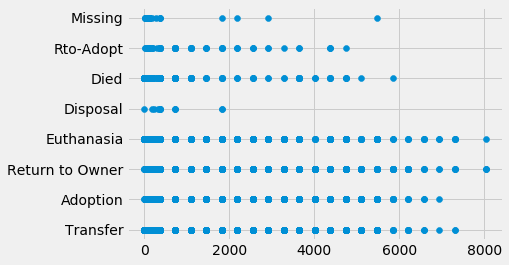

In [39]:
plt.scatter(cats_df['outcome_age_(days)'], cats_df['outcome_type'])

In [40]:
cats_df['outcome_subtype'].value_counts()

Partner           11340
Foster             4213
SCRP               3211
Snr                1585
Suffering          1444
In Kennel           272
In Foster           188
Offsite             110
Rabies Risk          73
Medical              65
At Vet               64
Enroute              20
In Surgery           10
Aggressive            4
Barn                  3
Possible Theft        2
Underage              1
Name: outcome_subtype, dtype: int64

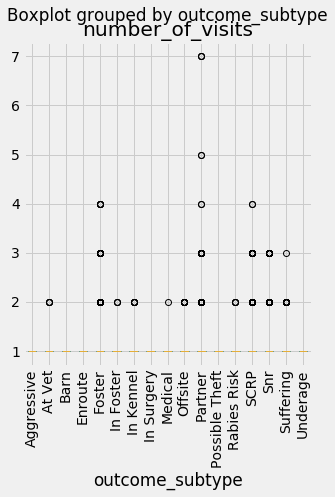

In [41]:
cats_df.boxplot('number_of_visits','outcome_subtype',rot = 90,figsize=(5,6))

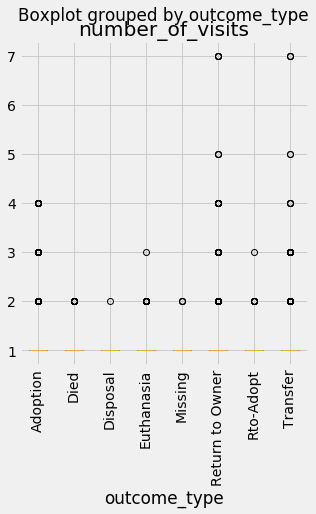

In [42]:
cats_df.boxplot('number_of_visits','outcome_type',rot = 90,figsize=(5,6))

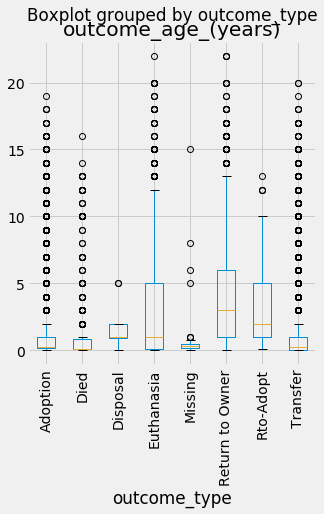

In [43]:
cats_df.boxplot('outcome_age_(years)','outcome_type',rot = 90,figsize=(5,6))

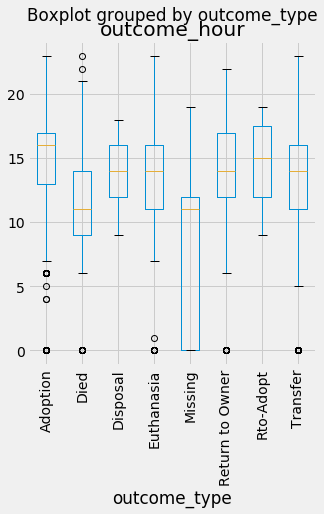

In [44]:
cats_df.boxplot('outcome_hour','outcome_type',rot = 90,figsize=(5,6))

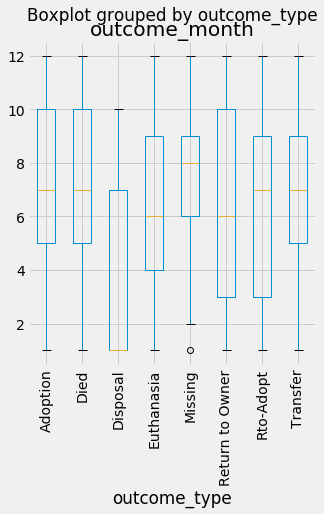

In [45]:
cats_df.boxplot('outcome_month','outcome_type',rot = 90,figsize=(5,6))

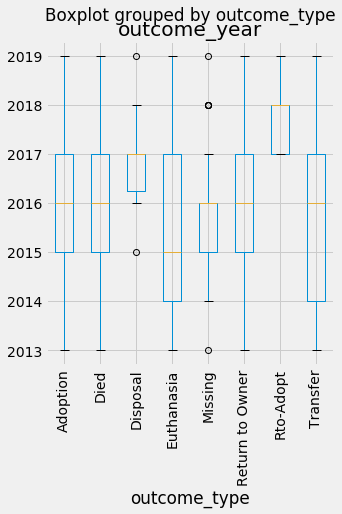

In [46]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


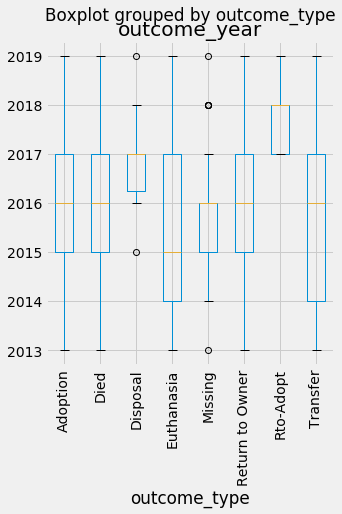

In [47]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


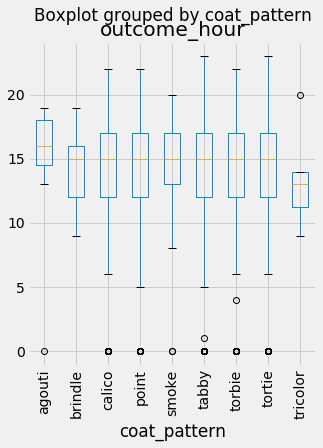

In [48]:
cats_df.boxplot('outcome_hour','coat_pattern',rot = 90,figsize=(5,6))


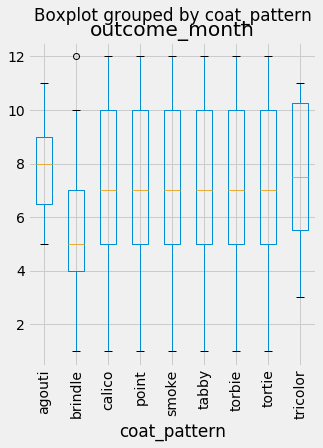

In [49]:
cats_df.boxplot('outcome_month','coat_pattern',rot = 90,figsize=(5,6))


Text(0,0.5,'Count')

Text(0.5,1,'Outcome Type')

Text(0,0.5,'Count')

Text(0.5,1,'Age Group')

Text(0,0.5,'Count')

Text(0.5,1,'Weekday')

Text(0,0.5,'Count')

Text(0.5,1,'Coat Pattern')

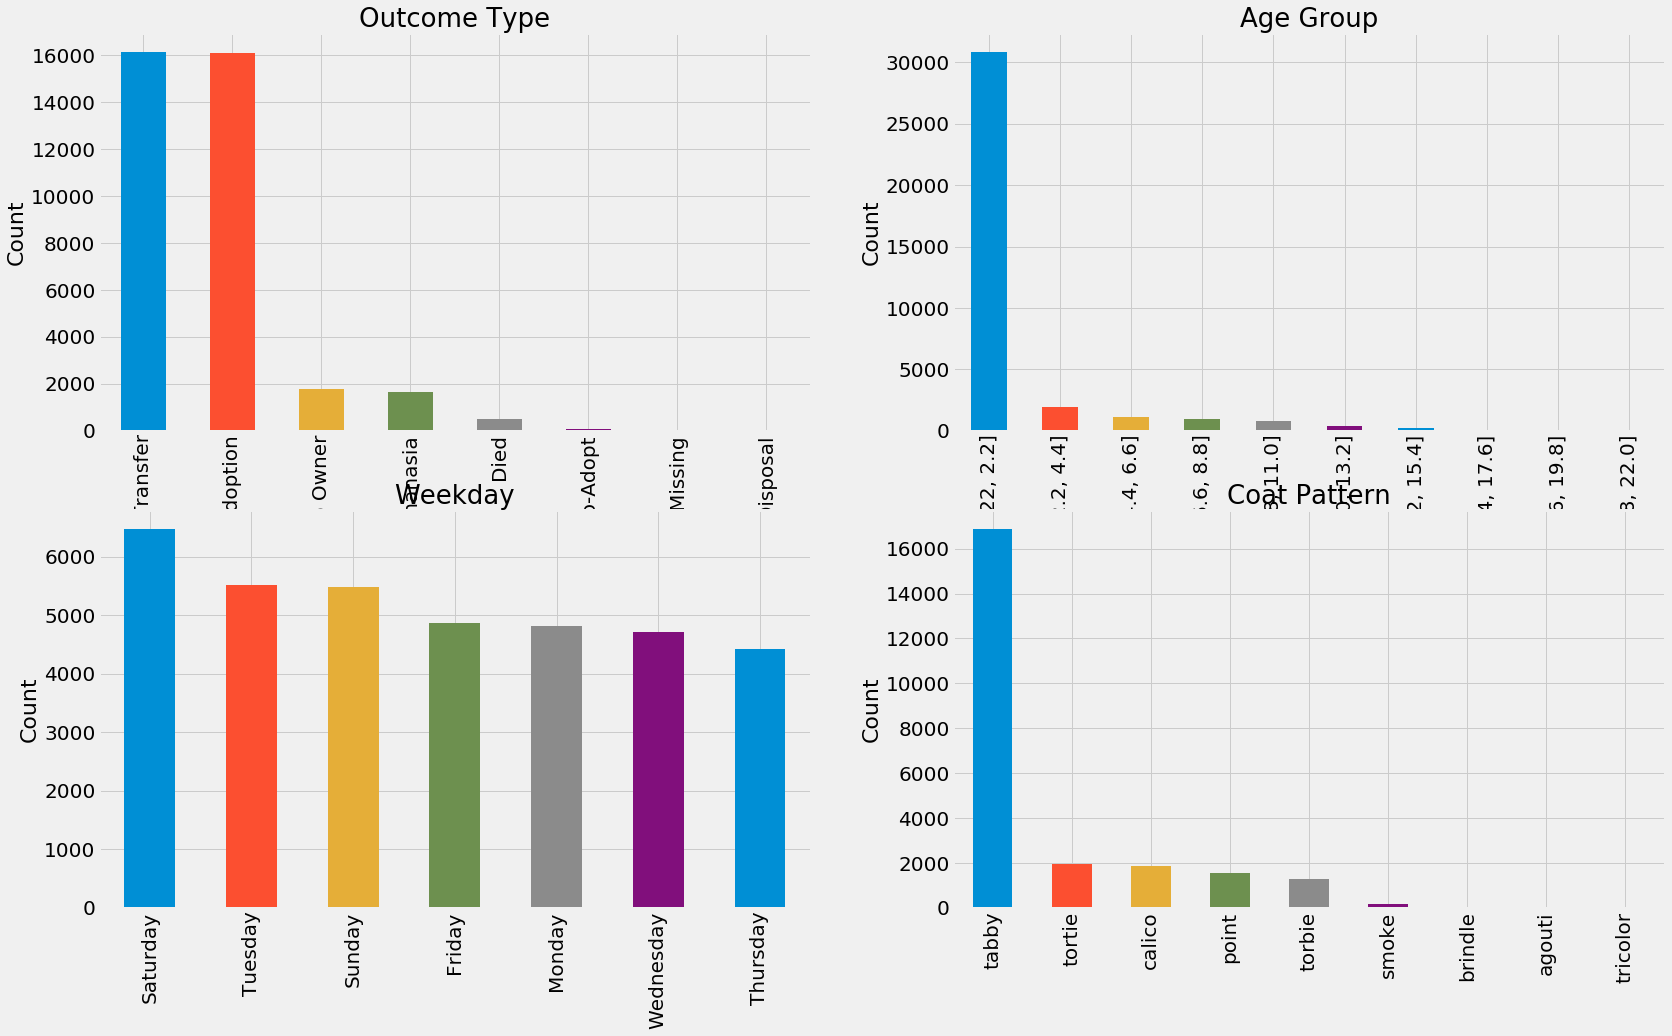

In [50]:
f, ax = plt.subplots(2, 2, figsize=(25, 15))

p1 = cats_df['outcome_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome Type', fontsize=26)

p2 = cats_df['age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Age Group', fontsize=26)

p3 = cats_df['outcome_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Weekday', fontsize=26)

p4 = cats_df['coat_pattern'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Coat Pattern', fontsize=26)

Text(0,0.5,'Count')

Text(0.5,1,'Outcome (Year)')

Text(0,0.5,'Count')

Text(0.5,1,'Outcome (Month)')

Text(0,0.5,'Count')

Text(0.5,1,'Outcome (Hour)')

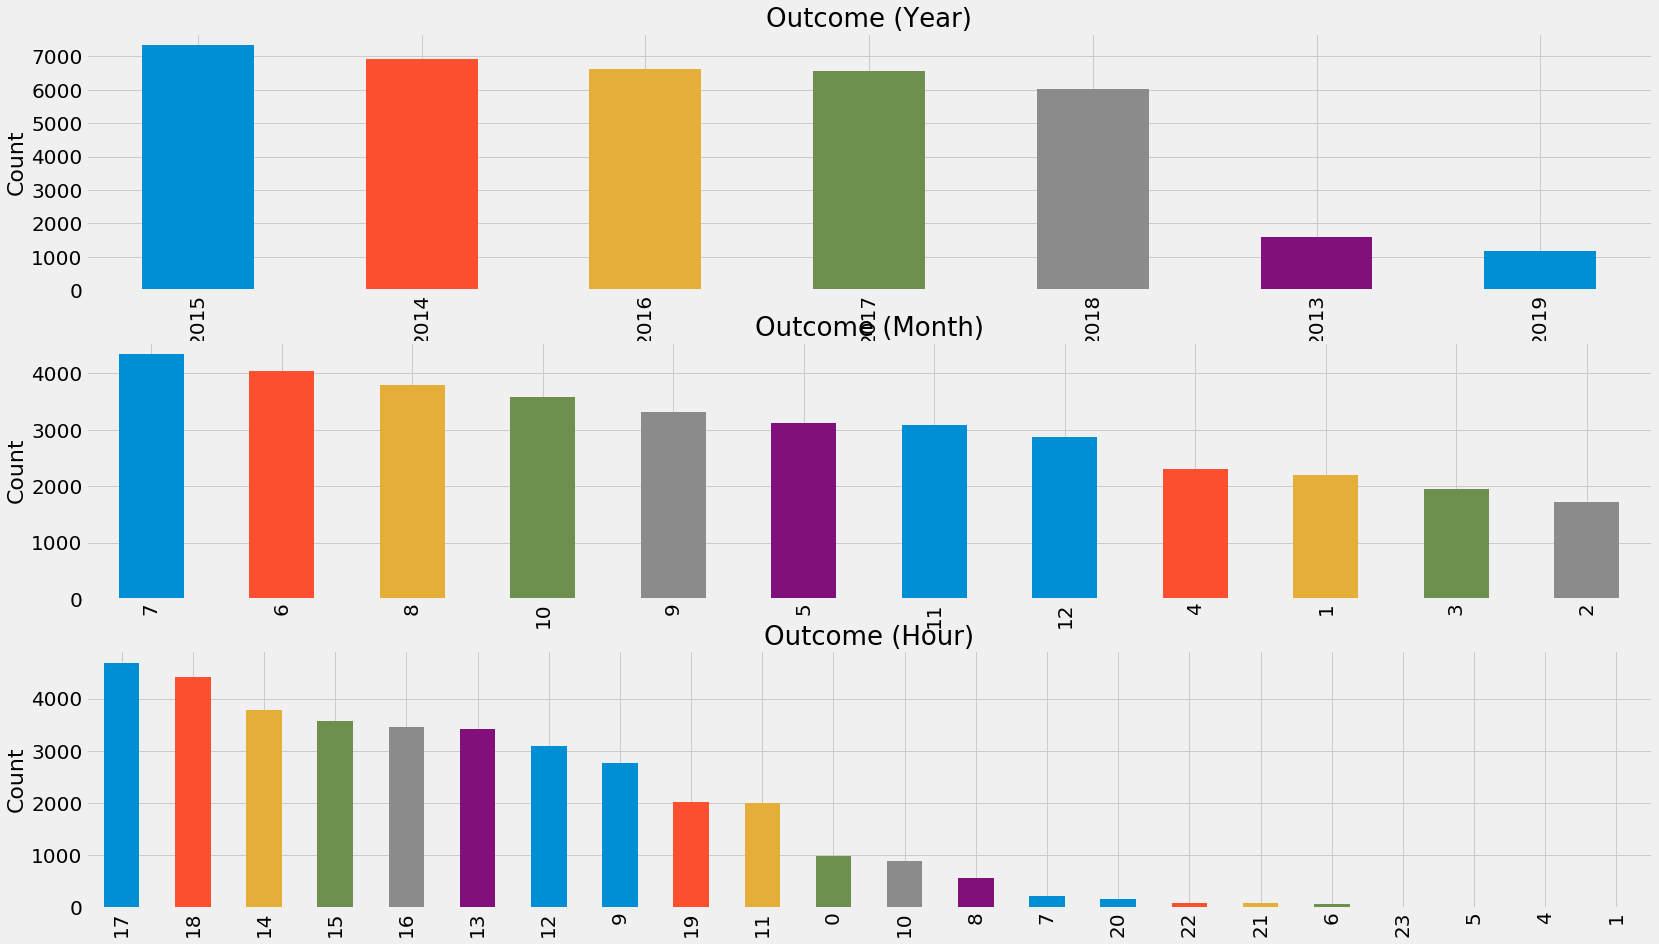

In [51]:
f, ax = plt.subplots(3, 1, figsize=(25, 15))

p1 = cats_df['outcome_year'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome (Year)', fontsize=26)

p2 = cats_df['outcome_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Outcome (Month)', fontsize=26)

p3 = cats_df['outcome_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Outcome (Hour)', fontsize=26)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,'Count')

Text(0.5,1,'Hourly Outcome')

Text(0,0.5,'Count')

Text(0.5,0,'Hour')

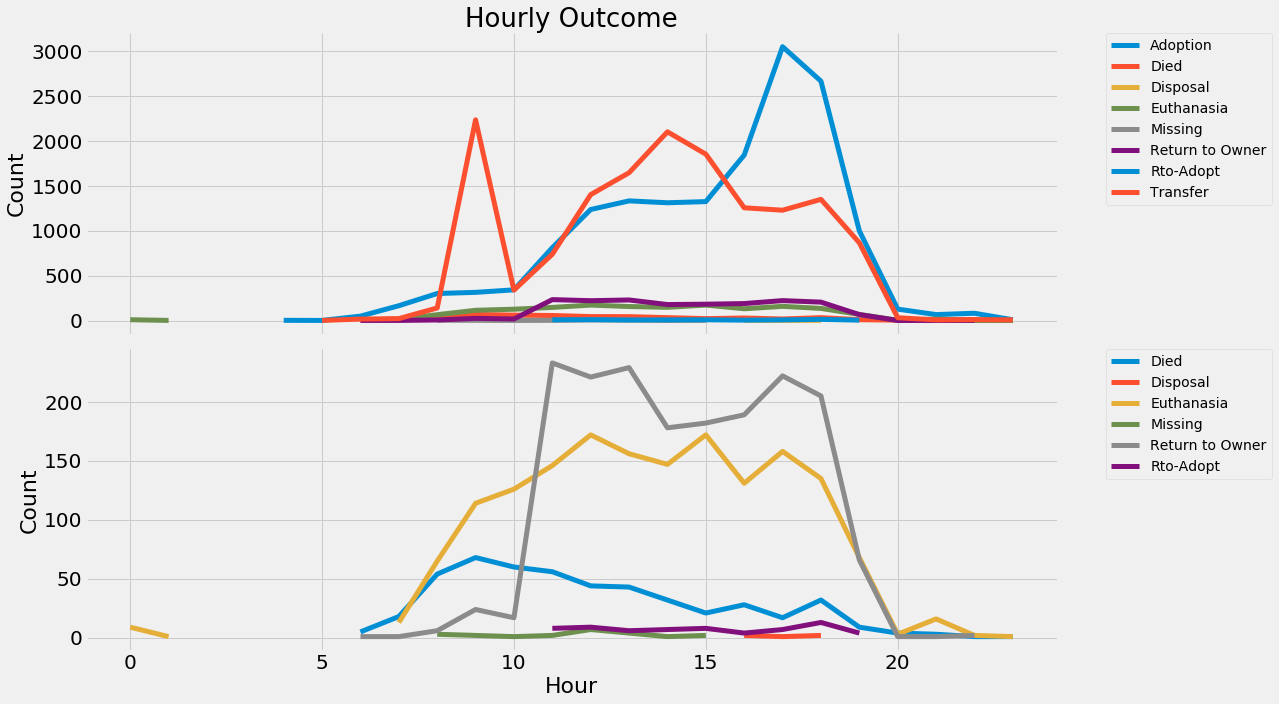

In [52]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Hourly Outcome', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Hour', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,'Count')

Text(0.5,1,'Monthly Outcome Volume')

Text(0,0.5,'Count')

Text(0.5,0,'Month')

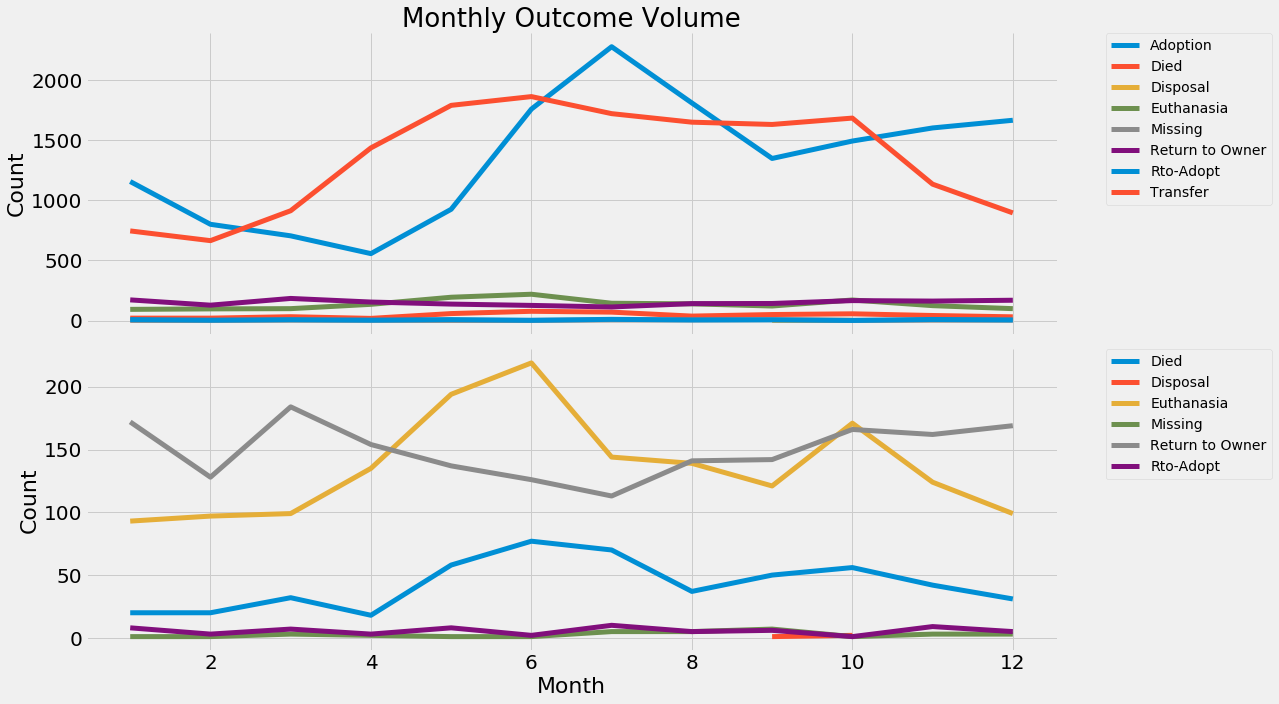

In [53]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Monthly Outcome Volume', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Month', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Some Stats

#### Conditional Probabilities

In [54]:
prob_kitten = cats_df.groupby('Kitten').size().div(len(cats_df))
cats_df.groupby(['Kitten', 'outcome_type']).size().div(len(cats_df)).div(prob_kitten)



Kitten  outcome_type   
0       Adoption           0.349364
        Died               0.009239
        Disposal           0.000852
        Euthanasia         0.066636
        Missing            0.000590
        Return to Owner    0.106212
        Rto-Adopt          0.003735
        Transfer           0.463373
1       Adoption           0.512239
        Died               0.017586
        Disposal           0.000048
        Euthanasia         0.029374
        Missing            0.001141
        Return to Owner    0.008223
        Rto-Adopt          0.000475
        Transfer           0.430914
dtype: float64

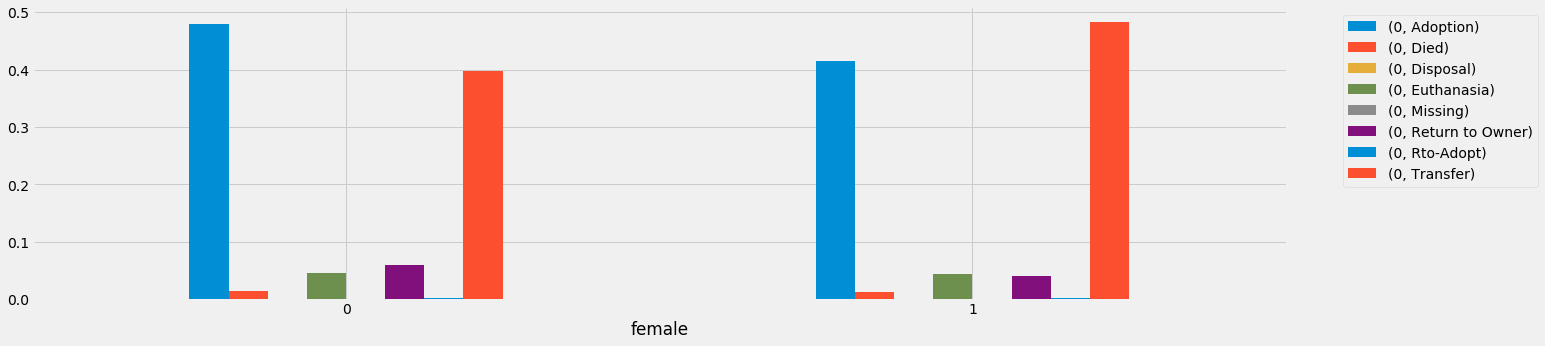

In [55]:
female_probabilities = cats_df.groupby('female').size().div(len(cats_df))
females = cats_df.groupby(['female', 'outcome_type']).size().div(len(cats_df)).div(female_probabilities)
females_df = females.to_frame()
plt = females_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


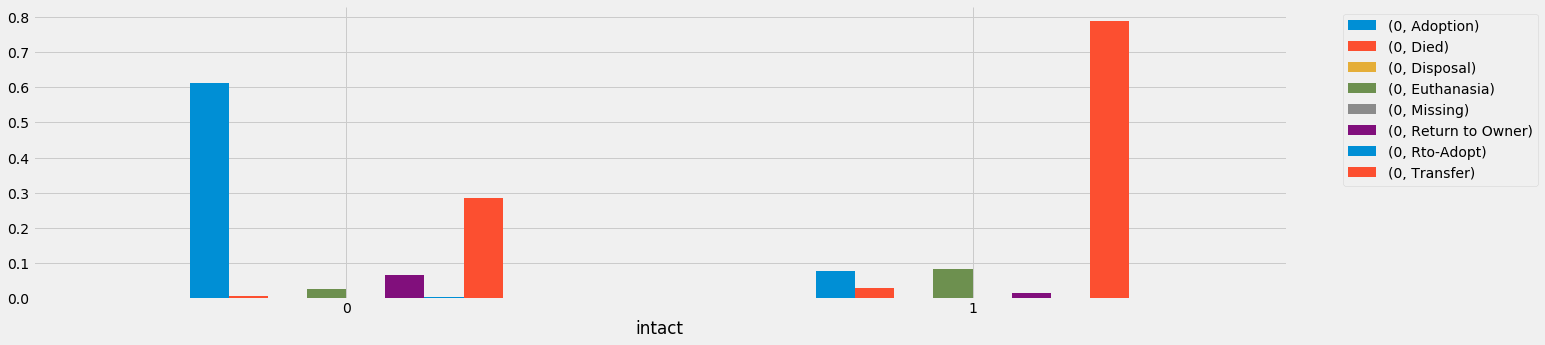

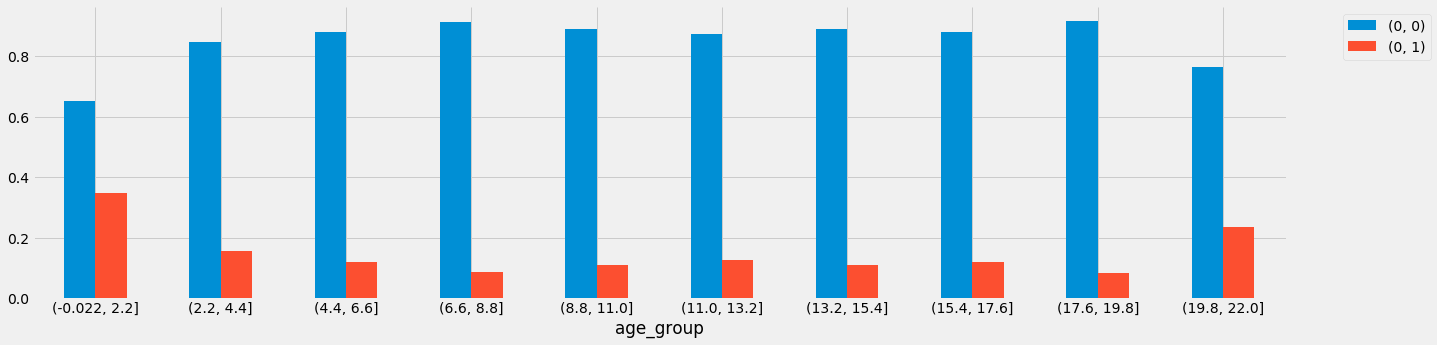

In [56]:
# Intact cats are more prone to dieing vs ones that are spayed/neutuered. Taking this one step further, intact cats
# are more likely to be really young, or very old, so there will likely be some form of correlation between these
# three variables. Something to explore?

intact_probabilities = cats_df.groupby('intact').size().div(len(cats_df))
intact = cats_df.groupby(['intact', 'outcome_type']).size().div(len(cats_df)).div(intact_probabilities)
intact_df = intact.to_frame()
plt = intact_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

age_probabilities = cats_df.groupby('age_group').size().div(len(cats_df))
age = cats_df.groupby(['age_group', 'intact']).size().div(len(cats_df)).div(age_probabilities)
age_df = age.to_frame()
plt = age_df.unstack('intact').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


Text(0.5,1,'Correlation of Variables')

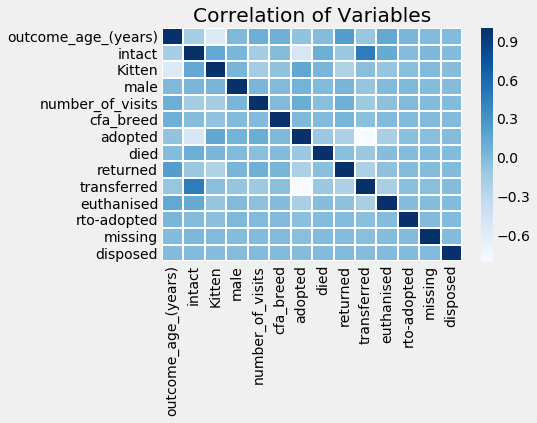

In [57]:
## exploring correlation between age_group and intact and death!
corr_df = pd.DataFrame()
corr_df['outcome_age_(years)'] = cats_df['outcome_age_(years)']
corr_df['intact'] = cats_df['intact']
corr_df['Kitten'] = cats_df['Kitten']
corr_df['male'] = cats_df['male']
corr_df['color'] = cats_df['color']
corr_df['number_of_visits'] = cats_df['number_of_visits']
corr_df['cfa_breed'] = cats_df['cfa_breed']
corr_df['outcome_weekday'] = cats_df['outcome_weekday']
corr_df['coat_pattern'] = cats_df['coat_pattern']
corr_df['adopted'] = cats_df['adopted']
corr_df['died'] = cats_df['died']
corr_df['returned'] = cats_df['returned']
corr_df['transferred'] = cats_df['transferred']
corr_df['euthanised'] = cats_df['euthanised']
corr_df['rto-adopted'] = cats_df['rto-adopted']
corr_df['missing'] = cats_df['missing']
corr_df['disposed'] = cats_df['disposed']
# plot the heatmap
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(corr_df.corr(), cmap="Blues",linewidths=1, ax=ax)
ax.set_title('Correlation of Variables')
plt.show()

### Some interesting  correlation outcomes

1) Intact VS Kitten

2) Number of visits VS age at outcome

3) Dead VS Intact

4) Outcome age VS CFA Breed

5) Transferred VS Intact

6) Adopted VS Kitten

7) Returned VS Age

8) Euthanised VS Age

9) Euthanised VS Intact

### Contingency Table and Chi^2

In [58]:
crosstab = pd.crosstab(cats_df['died'], cats_df['intact'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

319.43237881745114

1.925492187103013e-71

In [59]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

716.033024114457

9.756038219906633e-158

In [60]:
crosstab = pd.crosstab(cats_df['adopted'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

949.9772059404631

1.3418323747503338e-208

In [61]:
crosstab = pd.crosstab(cats_df['Kitten'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

36301.0

0.0

In [62]:
crosstab = pd.crosstab(cats_df['number_of_visits'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

1566.3107202221802

1.1605313603666982e-203

In [63]:
crosstab = pd.crosstab(cats_df['returned'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

2891.341910431736

0.0

In [64]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['transferred'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

8048.75217398008

0.0

### Binary Logistic Model

In [65]:
cats_df.head()

,animal_id,color,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,count,male,female,...,coat_pattern,number_of_visits,adopted,died,returned,transferred,euthanised,rto-adopted,missing,disposed
0,A792419,,2017-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,0,1,...,calico,1,0,0,0,1,0,0,0,0
1,A792450,orange,2018-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,1,0,...,tabby,1,0,0,0,1,0,0,0,0
2,A791174,,2012-03-22,2019-04-14 17:41:00,2019-04-14T17:41:00.000,NaN,Adoption,1,0,1,...,tortie,1,1,0,0,0,0,0,0,0
3,A792724,blue,2019-04-12,2019-04-14 16:54:00,2019-04-14T16:54:00.000,Partner,Transfer,1,1,0,...,tabby,1,0,0,0,1,0,0,0,0
4,A792566,gray,2018-11-12,2019-04-14 16:45:00,2019-04-14T16:45:00.000,NaN,Adoption,1,1,0,...,tabby,1,1,0,0,0,0,0,0,0


In [66]:
cats_df.columns

Index(['animal_id', 'color', 'date_of_birth', 'datetime', 'monthyear',
       'outcome_subtype', 'outcome_type', 'count', 'male', 'female',
       'spayed_or_neutered', 'intact', 'outcome_age_(days)',
       'outcome_age_(years)', 'Cat', 'Kitten', 'age_group', 'dob_year',
       'dob_month', 'dob_monthyear', 'outcome_month', 'outcome_year',
       'outcome_weekday', 'outcome_hour', 'cfa_breed', 'domestic_breed',
       'coat_pattern', 'number_of_visits', 'adopted', 'died', 'returned',
       'transferred', 'euthanised', 'rto-adopted', 'missing', 'disposed'],
      dtype='object')

In [68]:
# Outcome by Cat/Kitten
# sns.catplot(data = cats_df, x = "Kitten", kind = "count", hue = "adopted")

In [69]:
# Outcome by Sex
# sns.catplot(data = cats_df, x = "male", kind = "count", hue = "adopted")

AttributeError: module 'seaborn' has no attribute 'catplot'

In [ ]:
# Outcome by spay/neuter
sns.catplot(data = cats_df, x = "spayed_or_neutered", kind = "count", hue = "adopted")

In [ ]:
# Outcome by cfa breed
sns.catplot(data = cats_df, x = "cfa_breed", kind = "count", hue = "adopted")

In [ ]:
# Outcome by coat pattern
sns.catplot(data = cats_df, x = "coat_pattern", kind = "count", hue = "adopted")

In [ ]:
# Outcome ages
sns.catplot(data = cats_df, x = "adopted", y = "outcome_age_(years)", kind = "boxen")

In [70]:
interest = cats_df.loc[:, ['male', 'spayed_or_neutered', 'Kitten', 
                           'outcome_age_(years)', 'cfa_breed', 'coat_pattern', 'adopted']]

# recode coat patterns for 5 most frequent coat combinations
interest['coat_tabby'] = np.where(interest['coat_pattern'] == 'tabby', 1, 0)
interest['coat_tortie'] = np.where(interest['coat_pattern'] == 'tortie', 1, 0)
interest['coat_torbie'] = np.where(interest['coat_pattern'] == 'torbie', 1, 0)
interest['coat_point'] = np.where(interest['coat_pattern'] == 'point', 1, 0)
interest['coat_calico'] = np.where(interest['coat_pattern'] == 'calico', 1, 0)
interest = interest.drop(['coat_pattern'], axis=1)

In [71]:
# add intercept
interest['Intercept'] = 1.0

# convert to float
interest = interest.astype(float)

interest.head()

,male,spayed_or_neutered,Kitten,outcome_age_(years),cfa_breed,adopted,coat_tabby,coat_tortie,coat_torbie,coat_point,coat_calico,Intercept
0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,7.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.005479,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.410959,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [72]:
model = sm.Logit(interest.loc[:, ['adopted']], 
                 interest.loc[:, ['Intercept',
                                  'Kitten',
                                  'cfa_breed',
                                  'male',
                                  'spayed_or_neutered',
                                  'coat_tabby',
                                  'coat_tortie',
                                  'coat_torbie',
                                  'coat_point',
                                  'coat_calico',
                                  'outcome_age_(years)'
                                 ]])

In [73]:
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.495626
         Iterations 7


In [74]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                adopted   No. Observations:                36301
Model:                          Logit   Df Residuals:                    36290
Method:                           MLE   Df Model:                           10
Date:                Sun, 14 Apr 2019   Pseudo R-squ.:                  0.2784
Time:                        20:46:23   Log-Likelihood:                -17992.
converged:                       True   LL-Null:                       -24932.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.0635      0.054    -75.593      0.000      -4.169      -3.958
Kitten                  1.3179      0.032     41.075      0.000       1.255       1.381
cfa_breed       

In [75]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(interest.loc[:, ['Intercept',
                                  'Kitten',
                                  'cfa_breed',
                                  'male',
                                  'spayed_or_neutered',
                                  'coat_tabby',
                                  'coat_tortie',
                                  'coat_torbie',
                                  'coat_point',
                                  'coat_calico',
                                  'outcome_age_(years)'
                                 ]],
                                                    interest.loc[:, ['adopted']], test_size=0.30, 
                                                    random_state=101)

In [76]:
x_train.head()
x_train.shape
y_train.head()
y_train.shape

,Intercept,Kitten,cfa_breed,male,spayed_or_neutered,coat_tabby,coat_tortie,coat_torbie,coat_point,coat_calico,outcome_age_(years)
35785,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.246575
5777,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.739726
34215,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.739726
4187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000
1060,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.410959


(25410, 11)

,adopted
35785,1.0
5777,1.0
34215,1.0
4187,0.0
1060,0.0


(25410, 1)

In [77]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(x_train,y_train)
logmodel.coef_
predictions = logmodel.predict(x_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

array([[-2.03861831,  1.32271634,  0.29820249,  0.69558805,  3.42844796,
         0.11988276,  0.70849778,  0.91737029,  0.22882467,  0.92859311,
        -0.02619183]])

In [79]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.79      0.73      0.76      6081
        1.0       0.68      0.75      0.72      4810

avg / total       0.74      0.74      0.74     10891



In [80]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions, [0.0, 1.0])
print(confusion_matrix)

[[4409 1672]
 [1186 3624]]


In [81]:
print('accuracy ', (4409 + 3624)/10891)

accuracy  0.7375814893030943


Text(0.5,1.05,'Confusion matrix of the classifier')

[Text(0,1,''), Text(0,1,'0.0'), Text(0,1,'1.0')]

[Text(0,0,''), Text(0,0,'0.0'), Text(0,0,'1.0')]

Text(0.5,0,'True')

Text(0,0.5,'Predicted')

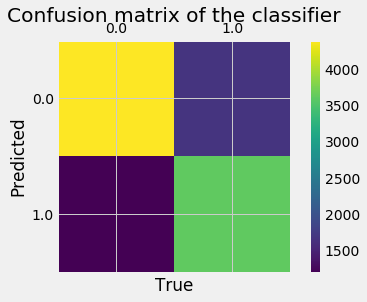

In [82]:
fig = plt.figure()
labels = [0.0, 1.0]
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'False Positive Rate')

Text(0,0.5,'True Positive Rate')

Text(0.5,1,'Receiver operating characteristic')

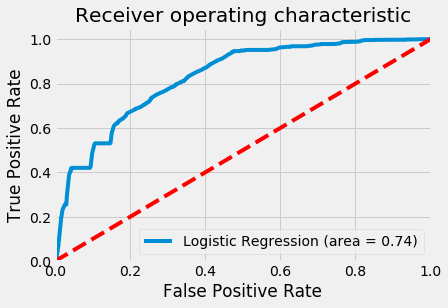

In [83]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

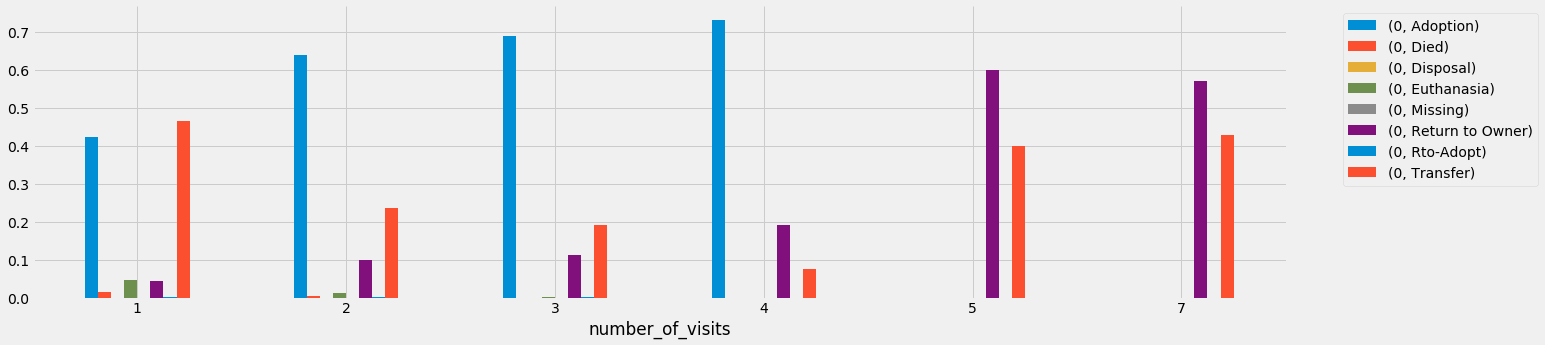

In [65]:
num_of_visits_probabilities = cats_df.groupby('number_of_visits').size().div(len(cats_df))
number_of_visits = cats_df.groupby(['number_of_visits', 'outcome_type']).size().div(len(cats_df)).div(num_of_visits_probabilities)
number_of_visits_df = number_of_visits.to_frame()
plt = number_of_visits_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


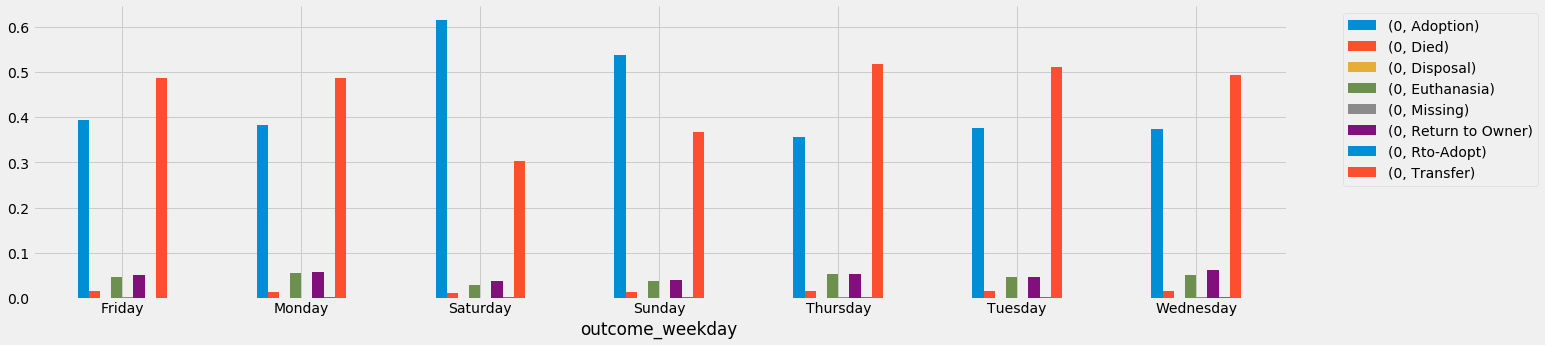

In [66]:
weekday_probabilities = cats_df.groupby('outcome_weekday').size().div(len(cats_df))
weekdays = cats_df.groupby(['outcome_weekday', 'outcome_type']).size().div(len(cats_df)).div(weekday_probabilities)
weekdays_df = weekdays.to_frame()
plt = weekdays_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


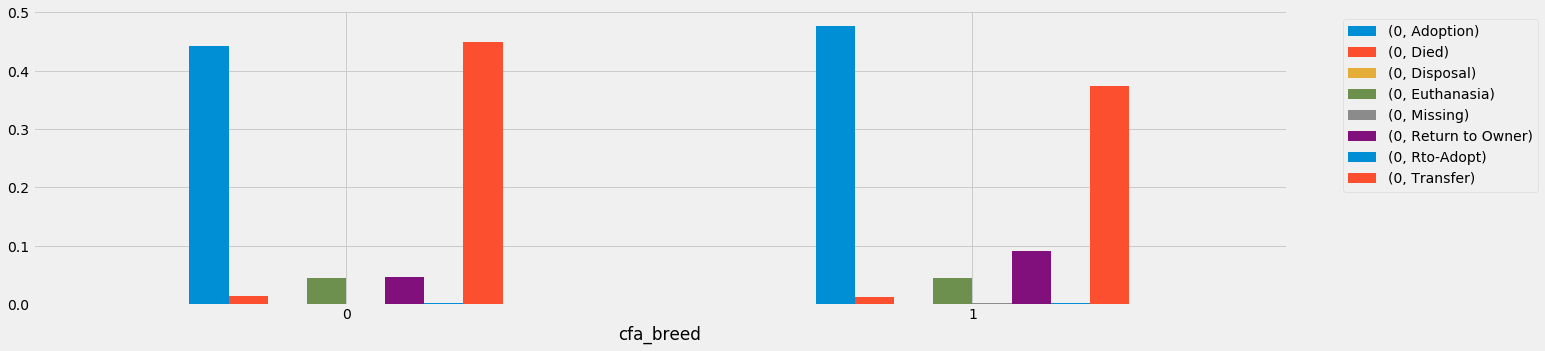

In [67]:
cfa_breed_probabilities = cats_df.groupby('cfa_breed').size().div(len(cats_df))
cfa_breed = cats_df.groupby(['cfa_breed', 'outcome_type']).size().div(len(cats_df)).div(cfa_breed_probabilities)
cfa_breed_df = cfa_breed.to_frame()
plt = cfa_breed_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


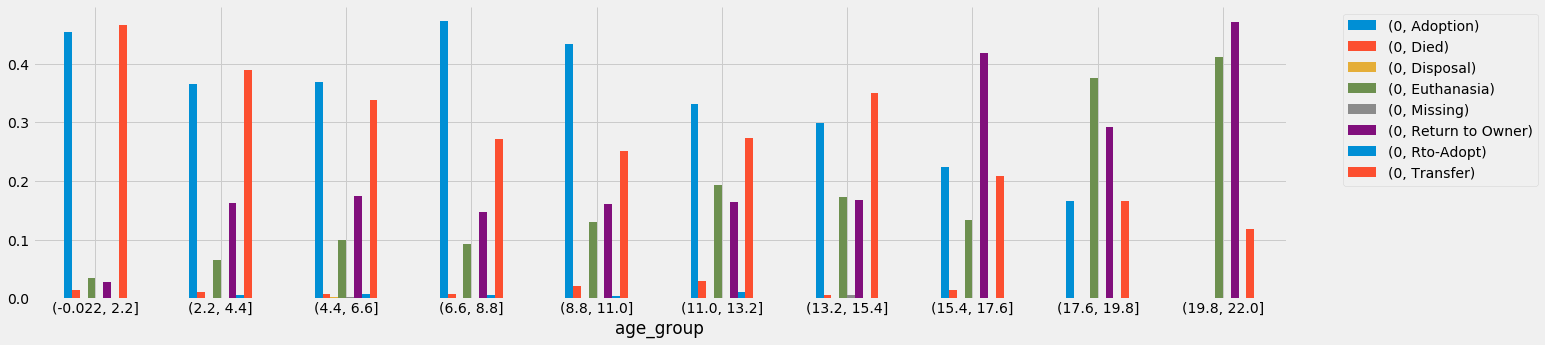

In [68]:
age_group_probabilities = cats_df.groupby('age_group').size().div(len(cats_df))
age_group = cats_df.groupby(['age_group', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


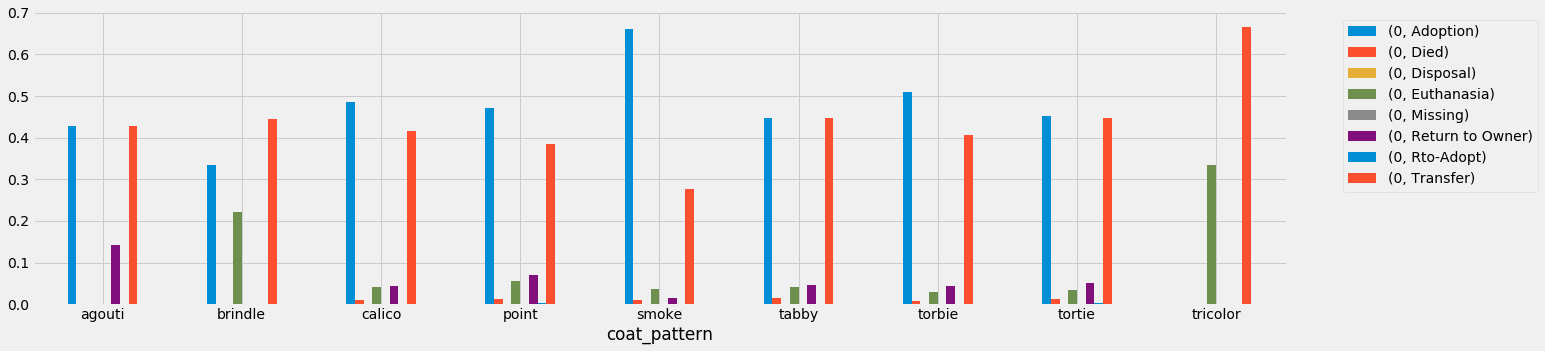

In [69]:
coat_pattern_probabilities = cats_df.groupby('coat_pattern').size().div(len(cats_df))
coat_pattern = cats_df.groupby(['coat_pattern', 'outcome_type']).size().div(len(cats_df)).div(coat_pattern_probabilities)
coat_pattern_df = coat_pattern.to_frame()
plt = coat_pattern_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


In [70]:
___________________________________________________________________________________________

NameError: name '___________________________________________________________________________________________' is not defined

In [71]:
### lets try some poison

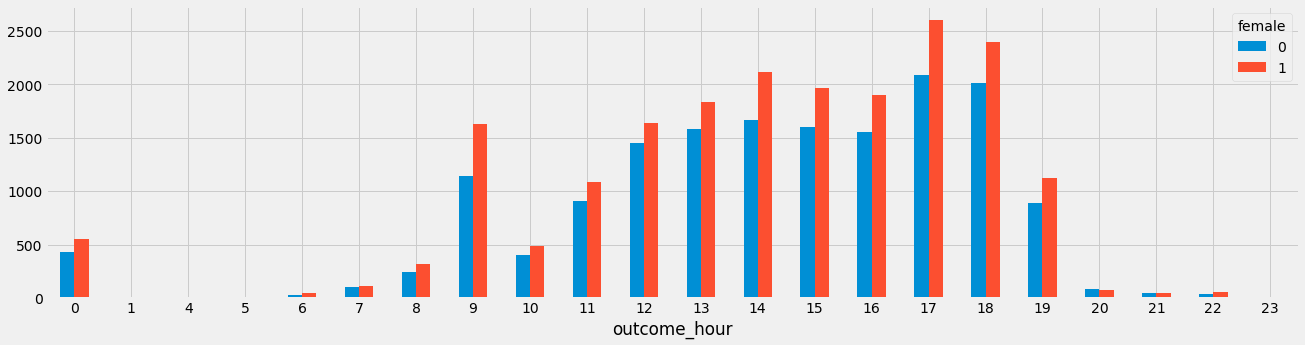

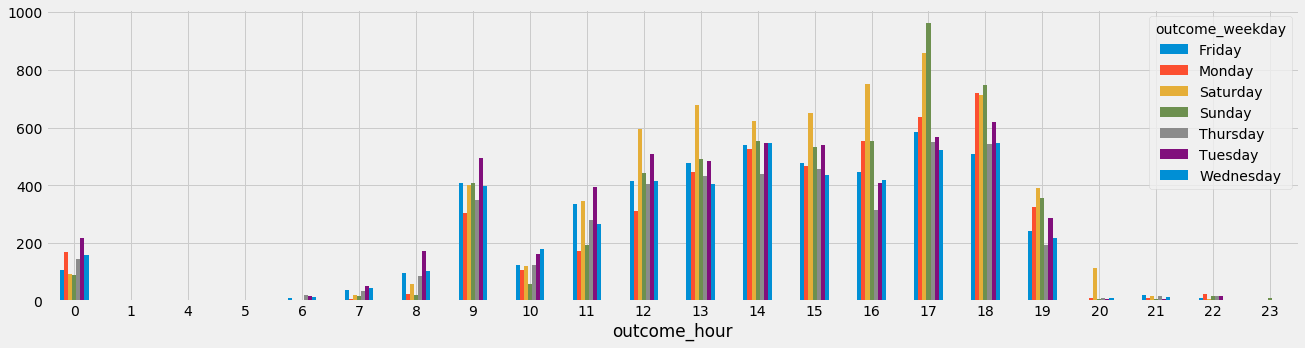

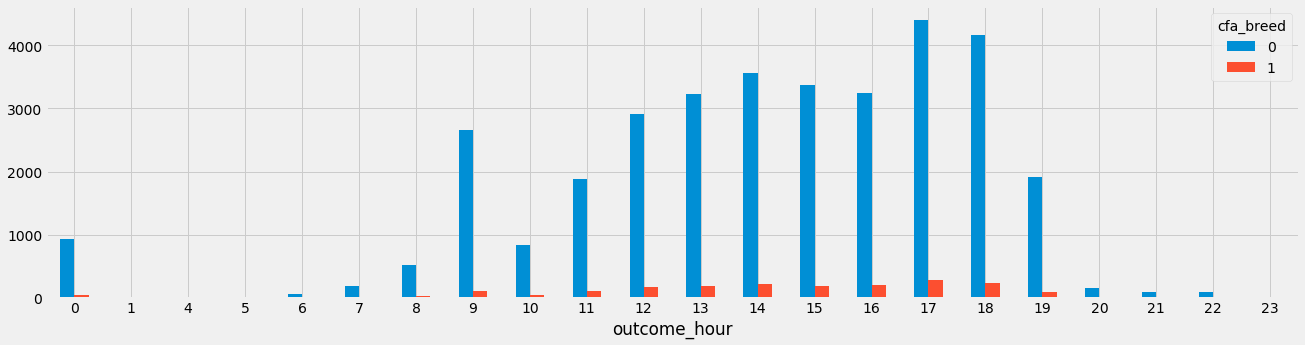

In [72]:
hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['female'], 
                              values='count', aggfunc=np.sum)

hourly_outcome.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

outcome_weekday = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_weekday'], 
                              values='count', aggfunc=np.sum)

outcome_weekday.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

cfa_breed = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['cfa_breed'], 
                              values='count', aggfunc=np.sum)

cfa_breed.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

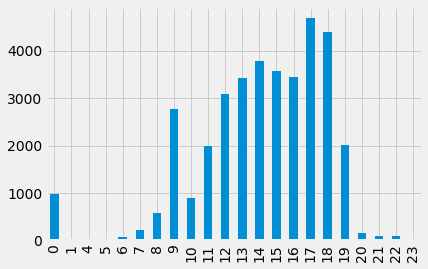

In [73]:
cats_df["outcome_hour"].value_counts().sort_index().plot(kind='bar')

In [74]:
# _____________________________________________________________________________________________________

In [75]:
### Multinomial Regression
# want to create the following:
# X_TRAIN = [[outcome year, outcome_month, outcome_hour, outcome_age_(years), number_of_visits], ...]
# y_TRAIN = [outcome_type ...]

without_adoption_df = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
without_adoption_df = without_adoption_df[~cats_df['outcome_type'].str.contains('Transfer')]

C:\Users\Dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [76]:
X_TRAIN = cats_df[['female', 'spayed_or_neutered', 'Kitten', 'outcome_hour', 'outcome_age_(years)', 'number_of_visits']].values.tolist()

In [77]:
Y_TRAIN, ynames = pd.factorize(cats_df['outcome_subtype'])

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2)

In [79]:
X_test

[[0.0, 1.0, 1.0, 17.0, 0.1643835616438356, 1.0],
 [1.0, 1.0, 1.0, 11.0, 0.3287671232876712, 1.0],
 [0.0, 1.0, 1.0, 0.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 1.0, 13.0, 0.2465753424657534, 1.0],
 [0.0, 1.0, 0.0, 9.0, 3.0, 2.0],
 [0.0, 1.0, 0.0, 18.0, 6.0, 1.0],
 [1.0, 1.0, 0.0, 11.0, 3.0, 1.0],
 [0.0, 1.0, 1.0, 16.0, 0.1643835616438356, 2.0],
 [1.0, 1.0, 1.0, 16.0, 0.1643835616438356, 1.0],
 [1.0, 0.0, 1.0, 14.0, 0.0821917808219178, 1.0],
 [1.0, 0.0, 0.0, 16.0, 1.0, 1.0],
 [0.0, 1.0, 0.0, 17.0, 5.0, 1.0],
 [1.0, 0.0, 0.0, 14.0, 2.0, 1.0],
 [1.0, 1.0, 0.0, 12.0, 4.0, 1.0],
 [0.0, 1.0, 1.0, 19.0, 0.1643835616438356, 1.0],
 [0.0, 1.0, 0.0, 13.0, 5.0, 1.0],
 [1.0, 0.0, 1.0, 14.0, 0.019178082191780823, 1.0],
 [1.0, 0.0, 0.0, 19.0, 2.0, 1.0],
 [0.0, 0.0, 1.0, 9.0, 0.2465753424657534, 1.0],
 [1.0, 1.0, 0.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 0.0, 14.0, 0.821917808219178, 1.0],
 [0.0, 0.0, 1.0, 12.0, 0.0821917808219178, 1.0],
 [1.0, 0.0, 1.0, 9.0, 0.038356164383561646, 1.0],
 [1.0, 1.0, 0.0, 15.0, 0.

In [80]:
y_test[0:100]

array([-1, -1,  1,  4,  4, -1,  1, -1, -1,  1,  1, -1, 14,  1, -1, -1,  1,
        0, 14,  0,  1,  1,  3, -1,  0, -1,  1, -1,  0,  1, -1,  1, -1,  4,
       -1,  1,  4, -1,  1,  1, -1, -1,  2, -1, -1,  1, -1,  2,  1, -1,  1,
       -1,  2,  4,  4, -1, -1,  1,  2, 14, -1, 14, 14, 12, -1,  1, 14,  1,
        1,  4,  1,  1,  4,  4, 14, -1,  4,  1,  1, 14, -1,  4, -1, 14,  1,
       -1,  1,  1,  1, -1,  4,  0,  1, -1, -1,  4,  1, -1,  2,  4],
      dtype=int64)

In [81]:
len(X_test)

7255

In [82]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

In [83]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_predicted = model.predict(X_test)
y_predicted.tolist()[0:20]
y_test[0:20]


[-1, 1, 4, -1, -1, -1, 1, -1, -1, 1, 14, -1, 14, -1, -1, -1, 1, 0, 1, 14]

array([-1, -1,  1,  4,  4, -1,  1, -1, -1,  1,  1, -1, 14,  1, -1, -1,  1,
        0, 14,  0], dtype=int64)

In [85]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
cm

array([[2301,    9,  276,    1,    0,   88,    0,    0,    0,    0,    0,
           0,    0,   29,    0,    0],
       [ 103,   82,   50,    0,    0,    3,    0,    0,    0,    0,    0,
           0,    0,   85,    0,    0],
       [ 826,   11, 1276,   12,    0,   63,    0,    0,    0,    0,    0,
           0,    0,  145,    0,    0],
       [  84,   20,  111,   13,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   45,    0,    0],
       [   8,    2,   37,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    4,    0,    0],
       [ 522,    0,  165,    0,    0,  120,    0,    0,    0,    0,    0,
           0,    0,   16,    0,    0],
       [   4,    0,    6,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,   43,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    0,    0],
       [   1,    0,    6,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [86]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

TypeError: 'Figure' object is not callable

In [87]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predicted))

Accuracy: 0.5626464507236388


In [88]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AttributeError: 'AxesSubplot' object has no attribute 'cm'

In [89]:
sns.set(font_scale=1.2)

plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.show()


TypeError: 'Figure' object is not callable

In [ ]:
# it looks like transfer, Rto-Adopt need better tuning....